# Correlated lifetimes
Assumption: both lifetimes are Gaussian  
Convention: first dimension is estimated lifetime, second dimension is true lifetime

Plots: lifetime is plotted in a heatmap, 3Dbar plots would also be possible (https://matplotlib.org/stable/gallery/mplot3d/3d_bars.html, https://stackoverflow.com/questions/43100082/how-to-plot-gradient-fill-on-the-3d-bars-in-matplotlib, https://stackoverflow.com/questions/8437788/how-to-correctly-generate-a-3d-histogram-using-numpy-or-matplotlib-built-in-func/51624315#51624315)

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import matplotlib as mpl

In [2]:
# max. lifetime
N_x, N_y = [10, 10]
# mean lifetime
mu_x, mu_y = [5, 5]
# standard deviation and correlation
sig_x, sig_y, corr = [2, 2, 0.5]

In [3]:
cov = [[sig_x**2, corr*sig_x*sig_y], [corr*sig_x*sig_y, sig_y**2]]

In [4]:
p = np.zeros((N_x, N_y))
for i in range(N_x):
    for j in range(N_y):
        x, y = [i+1, j+1]
        # truncation
        # - beginning
        if x == 1:
            x_prev = min(0, mu_x - 10*sig_x)
        else:
            x_prev = i
        if y == 1:
            y_prev = min(0, mu_y - 10*sig_y)
        else:
            y_prev = j
        # - end
        if x == N_x:
            x = mu_x + 10*sig_x
        if y == N_y:
            y = mu_y + 10*sig_y
        # compute probability                
        p[i,j] = multivariate_normal.cdf([x,y], mean = [mu_x, mu_y], cov = cov) \
                    - multivariate_normal.cdf([x, y_prev], mean = [mu_x, mu_y], cov = cov) \
                    - multivariate_normal.cdf([x_prev, y], mean = [mu_x, mu_y], cov = cov) \
                    + multivariate_normal.cdf([x_prev,y_prev], mean = [mu_x, mu_y], cov = cov)

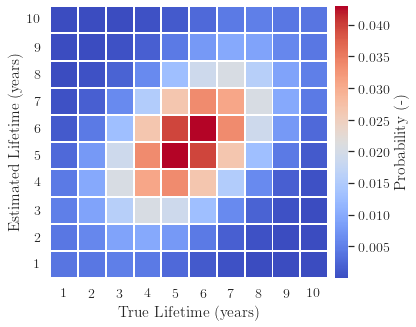

In [5]:
# plot: sns inverts x and y axis
plt.rc('text', usetex=True)
sns.set(context = "notebook", font_scale=1.3, rc={"lines.linewidth": 2.5, 'font.family':'serif', 'font.serif':['Computer Modern Roman'], 'text.usetex':True})
fig = plt.figure(figsize = (6, 5))
ax = sns.heatmap(p, xticklabels= 1 + np.arange(N_y), yticklabels= 1+np.arange(N_x),cmap=sns.color_palette("coolwarm",300),\
                 cbar_kws={'label': 'Probability (-)', 'pad':0.02}, linewidths=1, fmt='.3g')
plt.yticks(rotation=0)
plt.xlabel('True Lifetime (years)')
plt.ylabel('Estimated Lifetime (years)')
# plt.title('2019')
ax.invert_yaxis()
# ax.set_ylim(0,6)
fig.savefig('pics/life_corr.pdf',bbox_inches='tight')

## Decision: only reuse batteries with an estimated lifetime higher than $\ell_\min$

In [6]:
# reuse threshold
l_min = 2
p_reuse = p
p_reuse[:l_min,:] = np.nan

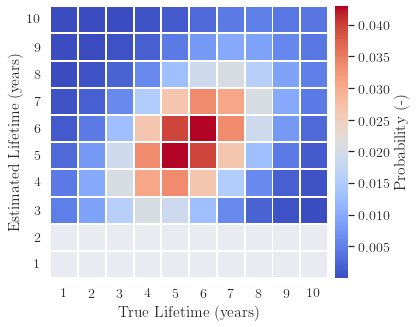

In [7]:
# plot: sns inverts x and y axis
plt.rc('text', usetex=True)
sns.set(context = "notebook", font_scale=1.3, rc={"lines.linewidth": 2.5, 'font.family':'serif', 'font.serif':['Computer Modern Roman'], 'text.usetex':True})
fig = plt.figure(figsize = (6, 5))
ax = sns.heatmap(p_reuse, yticklabels= 1 + np.arange(N_x),xticklabels= 1+np.arange(N_y),cmap=sns.color_palette("coolwarm",300),\
                 cbar_kws={'label': 'Probability (-)', 'pad':0.02}, linewidths=1, fmt='.3g')
plt.yticks(rotation=0)
plt.xlabel('True Lifetime (years)')
plt.ylabel('Estimated Lifetime (years)')
# plt.title('2019')
ax.invert_yaxis()
# ax.set_ylim(0,6)
fig.savefig('pics/life_corr_cut.pdf',bbox_inches='tight')

### Compute reuse factor and plot marginal distributions

In [8]:
p_reuse[:l_min,:] = 0
reuse_factor = p_reuse.sum()
print('The reuse factor is: '+str(round(reuse_factor, 2)))
# compute and normalize marginals
pm_est = p_reuse.sum(axis = 1) / reuse_factor
pm_true = p_reuse.sum(axis = 0) / reuse_factor

The reuse factor is: 0.93


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


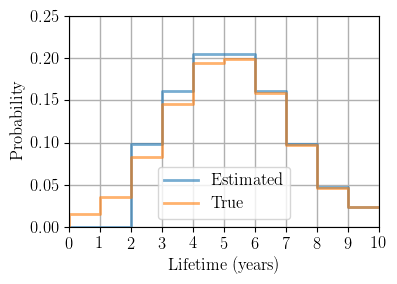

In [9]:
# layout
mpl.rc_file_defaults() # get rid of seaborn effects
transp = 0.6
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{eurosym}')
fig = plt.figure(figsize=[4, 2.75])
plt.rcParams.update({'font.size': 12})
# plot
plt.step(np.arange(N_x+1), np.concatenate([[0], pm_est]), label = 'Estimated', where = 'pre', alpha = transp, linewidth = 2)
plt.step(np.arange(N_y+1), np.concatenate([[0], pm_true]), label = 'True', where ='pre', alpha = transp, linewidth = 2)
# layout
plt.xlim(0,max(N_x, N_y))
plt.ylim(0, 0.25)
plt.xticks(np.arange(1+max(N_x, N_y)))
plt.grid(linewidth=1)
plt.xlabel('Lifetime (years)')
plt.ylabel('Probability')
plt.legend(frameon=True)
fig.savefig('pics/p_est_true.pdf',bbox_inches='tight')